## Model


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import os
import scipy

# ==========================================
# CONFIGURATION
# ==========================================
# Pointing directly to your local dataset path
# We use r"..." (raw string) to handle Windows backslashes correctly
DATASET_DIR = r"C:\Users\jaise\Downloads\dataset"
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
TEST_DIR = os.path.join(DATASET_DIR, 'test') 

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10 

# ==========================================
# 0. DIAGNOSTIC CHECK
# ==========================================
print(f"\n--- CHECKING DATA AT: {DATASET_DIR} ---")

if not os.path.exists(TRAIN_DIR):
    print(f"CRITICAL ERROR: Training folder not found at: {TRAIN_DIR}")
    print("Please verify the path exists and contains a 'train' folder.")
    exit()

total_train = 0
for d in os.listdir(TRAIN_DIR):
    d_path = os.path.join(TRAIN_DIR, d)
    if os.path.isdir(d_path):
        count = len([f for f in os.listdir(d_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        print(f"  Class '{d}': found {count} images")
        total_train += count

print(f"Total Training Images Found: {total_train}")

if total_train == 0:
    raise ValueError("Training data is missing. Check your folder structure.")

# ==========================================
# 1. DATA GENERATORS
# ==========================================
print("\n--- SETTING UP GENERATORS ---")

# We use validation_split to create a 20% internal validation set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 
)

print("Loading Training Set (80%):")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42 
)

print("Loading Validation Set (20%):")
val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42 
)

print("Loading Test Set:")
test_datagen_raw = ImageDataGenerator(rescale=1.0/255)

if os.path.exists(TEST_DIR):
    test_generator = test_datagen_raw.flow_from_directory(
        TEST_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=None, 
        shuffle=False 
    )
else:
    print(f"Warning: 'test' folder not found at {TEST_DIR}")
    test_generator = None

# ==========================================
# 2. MODEL ARCHITECTURE
# ==========================================
print("\n--- BUILDING MODEL ---")

base_model = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# ==========================================
# 3. TRAINING
# ==========================================
print(f"\n--- STARTING TRAINING ({EPOCHS} Epochs) ---")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

# Save model in the DATASET_DIR so it's easy to find
model_path = os.path.join(DATASET_DIR, 'ai_detector_model.keras')
model.save(model_path)
print(f"Model saved to: {model_path}")

# ==========================================
# 4. PREDICTION
# ==========================================
if test_generator and test_generator.samples > 0:
    print("\n--- GENERATING PREDICTIONS ---")
    predictions = model.predict(test_generator, verbose=1)
    
    filenames = test_generator.filenames
    results = pd.DataFrame({
        'id': filenames,
        'probability': predictions.flatten()
    })
    
    results['id'] = results['id'].apply(lambda x: os.path.basename(x))
    
    output_csv = os.path.join(DATASET_DIR, 'submission_results.csv')
    results.to_csv(output_csv, index=False)
    print(f"Predictions saved to: {output_csv}")
else:
    print("\nSkipping prediction (No test images found).")


--- CHECKING DATA AT: C:\Users\jaise\Downloads\dataset ---
  Class '0': found 33978 images
  Class '1': found 33979 images
Total Training Images Found: 67957

--- SETTING UP GENERATORS ---
Loading Training Set (80%):
Found 54367 images belonging to 2 classes.
Found 54367 images belonging to 2 classes.
Loading Validation Set (20%):
Found 13590 images belonging to 2 classes.
Loading Test Set:
Loading Validation Set (20%):
Found 13590 images belonging to 2 classes.
Loading Test Set:
Found 12042 images belonging to 1 classes.
Found 12042 images belonging to 1 classes.

--- BUILDING MODEL ---

--- BUILDING MODEL ---

--- STARTING TRAINING (10 Epochs) ---

--- STARTING TRAINING (10 Epochs) ---
Epoch 1/10
Epoch 1/10
1699/1699 ━━━━━━━━━━━━━━━━━━━━ 1448s 851ms/step - accuracy: 0.7496 - loss: 0.5025 - val_accuracy: 0.8451 - val_loss: 0.3726
Epoch 2/10
1699/1699 ━━━━━━━━━━━━━━━━━━━━ 1448s 851ms/step - accuracy: 0.7496 - loss: 0.5025 - val_accuracy: 0.8451 - val_loss: 0.3726
Epoch 2/10
1699/1699 

Visualisations

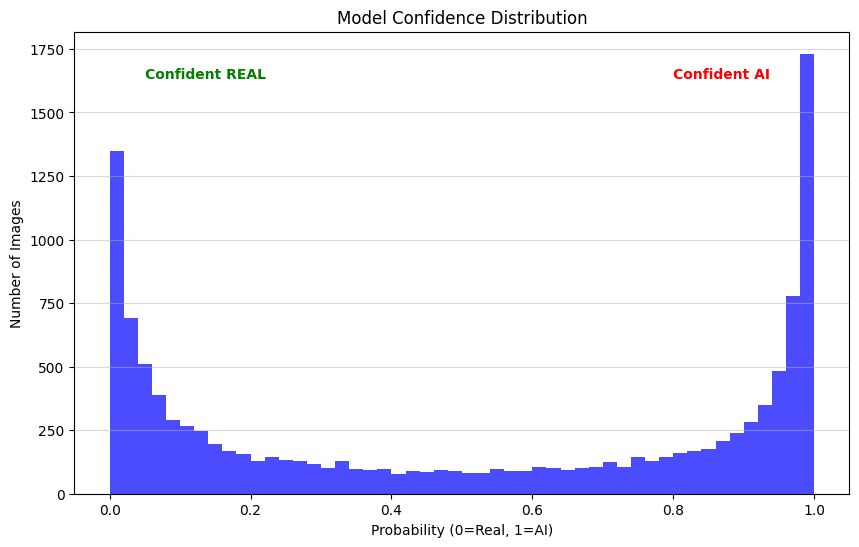

Graph generated! You want to see spikes on the left and right.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load your results
# Assuming the file is in the dataset folder
file_path = r"C:\Users\jaise\Downloads\dataset\submission_results.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path)

    plt.figure(figsize=(10, 6))
    plt.hist(df['probability'], bins=50, color='blue', alpha=0.7)
    plt.title('Model Confidence Distribution')
    plt.xlabel('Probability (0=Real, 1=AI)')
    plt.ylabel('Number of Images')
    plt.grid(axis='y', alpha=0.5)
    
    # Add labels
    plt.text(0.05, plt.ylim()[1]*0.9, 'Confident REAL', color='green', fontweight='bold')
    plt.text(0.80, plt.ylim()[1]*0.9, 'Confident AI', color='red', fontweight='bold')
    
    plt.show()
    print("Graph generated! You want to see spikes on the left and right.")
else:
    print("Could not find submission_results.csv. Check the path.")